In [1]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import utils

import warnings
warnings.filterwarnings('ignore')

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve,classification_report,auc,accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin # to create classes
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

In [2]:
train = pd.read_csv('data/train.csv', index_col='Unnamed: 0')
train

,timestamp,open,high,low,close,volume_(btc),volume_(currency),weighted_price,volumn_square,ma10,rsi30,rsi10,%k10,ema200,ma200,rsi200,%k30,ema10,signal
0,1340318100,6.64,6.64,6.64,6.64,2.019841,13.411742,6.640000,4.079757,6.643,50.380050,43.393527,0.000000,6.524184,6.52340,53.550844,0.0,6.646620,1.0
1,1340332500,6.64,6.64,6.64,6.64,54.000000,358.560000,6.640000,2916.000000,6.643,50.380050,43.393527,0.000000,6.525336,6.52460,53.550844,0.0,6.645416,1.0
2,1340333220,6.65,6.65,6.65,6.65,0.612030,4.070000,6.650000,0.374581,6.644,52.319942,50.382749,100.000000,6.526576,6.52585,53.681452,20.0,6.646250,1.0
3,1340340660,6.63,6.63,6.63,6.63,14.953557,99.142081,6.630000,223.608858,6.643,48.404673,39.535150,0.000000,6.527605,6.52700,53.379753,0.0,6.643295,1.0
4,1340344140,6.63,6.63,6.63,6.63,1.012382,6.712091,6.630000,1.024917,6.641,48.404673,39.535150,0.000000,6.528624,6.52815,53.379753,0.0,6.640878,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8591,1347807600,11.68,11.68,11.68,11.68,4.574098,53.425461,11.680000,20.922370,11.599,53.138831,59.328745,100.000000,11.550681,11.57415,51.979103,100.0,11.604982,0.0
8592,1347811380,11.56,11.56,11.56,11.56,18.000000,208.080000,11.560000,324.000000,11.592,46.677141,45.432977,14.285714,11.550774,11.57610,51.059579,20.0,11.596803,0.0
8593,1347811980,11.67,11.68,11.67,11.68,17.572500,205.212022,11.678021,308.792756,11.597,52.635301,56.701104,100.000000,11.552060,11.57770,51.914499,100.0,11.611930,0.0
8594,1347815340,11.62,11.62,11.62,11.62,0.199656,2.320000,11.620000,0.039862,11.605,49.759442,50.865663,53.846154,11.552736,11.57865,51.462750,60.0,11.613397,0.0


# Check the balance

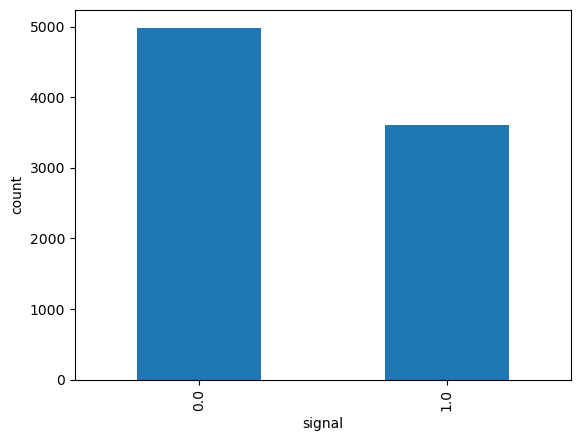

In [62]:
train.signal.value_counts().plot(kind='bar', xlabel = 'signal', ylabel = 'count')
plt.show()

# Feature Engineering

In [4]:
def EMA(df, n):
    EMA = pd.Series(df['close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA

#calculation of rate of change
def ROC(df, n):  
    M = df.diff(n - 1)  
    N = df.shift(n - 1)  
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))   
    return ROC

#Calculation of price momentum
def MOM(df, n):   
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))   
    return MOM

#calculation of relative strength index
def RSI(series, period):
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
    u = u.drop(u.index[:(period-1)])
    d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
    d = d.drop(d.index[:(period-1)])
    rs = u.ewm(com=period-1, adjust=False).mean() / \
    d.ewm(com=period-1, adjust=False).mean()
    return 100 - 100 / (1 + rs)

#calculation of stochastic osillator.

def STOK(close, low, high, n): 
    STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
    return STOK

def STOD(close, low, high, n):
    STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
    STOD = STOK.rolling(3).mean()
    return STOD

#Calculation of moving average
def MA(df, n):
    MA = pd.Series(df['close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA

# Backtest results
#Create column for Strategy Returns by multiplying the daily returns by the position that was held at close
#of business the previous day
def backtest(X_validation, Y_validation, predictions):
    backtestdata = pd.DataFrame(index=X_validation.index)
    backtestdata['signal_pred'] = predictions
    backtestdata['signal_actual'] = Y_validation
    backtestdata['Market Returns'] = X_validation['Close'].pct_change()
    backtestdata['Actual Returns'] = backtestdata['Market Returns'] * backtestdata['signal_actual'].shift(1)
    backtestdata['Strategy Returns'] = backtestdata['Market Returns'] * backtestdata['signal_pred'].shift(1)
    backtestdata=backtestdata.reset_index()
    backtestdata.head()
    backtestdata[['Strategy Returns','Actual Returns']].cumsum().hist()
    backtestdata[['Strategy Returns','Actual Returns']].cumsum().plot()
    
    return backtestdata

In [5]:
train = (train.assign(ema10 = lambda df: EMA(df, 10))
        .assign(ema30 = lambda df: EMA(df, 30))
        .assign(ema200 = lambda df: EMA(df, 200))
        .assign(roc10 = lambda df: ROC((df['close']), 10))
        .assign(roc30 = lambda df: ROC((df['close']), 30))
        .assign(mom10 = lambda df: MOM((df['close']), 10))
        .assign(mom30 = lambda df: MOM((df['close']), 30))
        .assign(rsi10 = lambda df: RSI((df['close']), 10))
        .assign(rsi30 = lambda df: RSI((df['close']), 30))
        .assign(rsi200 = lambda df: RSI((df['close']), 200)) 
        .assign(ma10 = lambda df: MA(df, 10))
        .assign(ma30 = lambda df: MA(df, 30))
        .assign(ma200 = lambda df: MA(df, 200))
                )

In [6]:
train.isnull().sum()

timestamp              0
open                   0
high                   0
low                    0
close                  0
volume_(btc)           0
volume_(currency)      0
weighted_price         0
volumn_square          0
ma10                   9
rsi30                 30
rsi10                 10
%k10                   0
ema200               199
ma200                199
rsi200               200
%k30                   0
ema10                  9
signal                 0
ema30                 29
roc10                  9
roc30                 29
mom10                 10
mom30                 30
ma30                  29
dtype: int64

In [7]:
test = pd.read_csv('data/test.csv')
test.columns = test.columns.str.lower()
train_columns = test.columns.to_list()
train_columns.append('signal') 
train = train.loc[:, train.columns.isin(train_columns)]
train.isnull().sum()

timestamp      0
close          0
ma10           9
rsi30         30
rsi10         10
%k10           0
ema200       199
ma200        199
rsi200       200
%k30           0
ema10          9
signal         0
ema30         29
roc10          9
roc30         29
mom10         10
mom30         30
ma30          29
dtype: int64

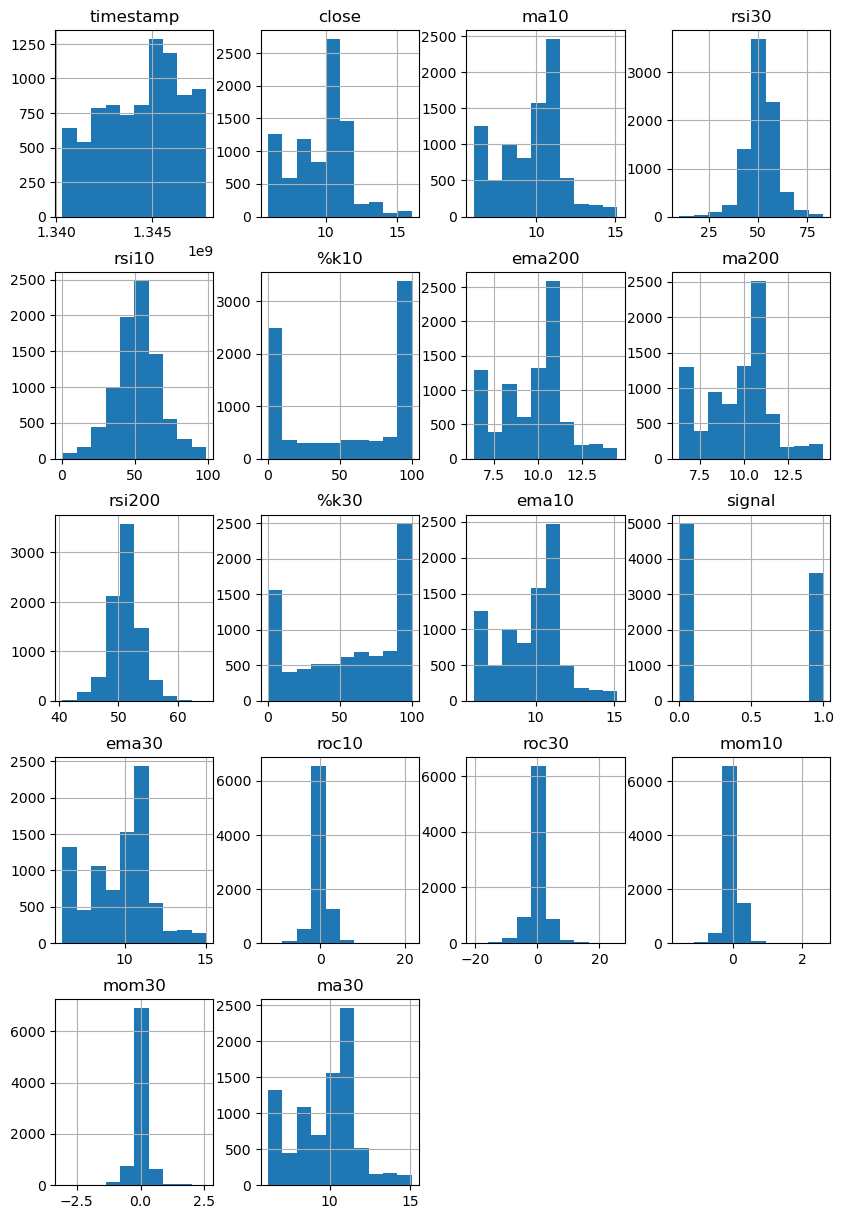

In [61]:
train.hist(figsize=(10,15))
plt.show()


In [25]:
X = train.drop(columns=['signal','timestamp'])
y = train['signal']
nums = ['close', 'ma10', 'rsi30', 'rsi10', '%k10', 'ema200', 'ma200', 'rsi200',
       '%k30', 'ema10', 'ema30', 'roc10', 'roc30', 'mom10', 'mom30', 'ma30']


# Preprocessing and Scalling

In [11]:
def preprocessing_scalling(data):
    data = data.fillna(data.median())
    rs = RobustScaler().fit(data)
    X_scaled = rs.transform(data)
    return X_scaled
X = preprocessing_scalling(X)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

# Trying Multiple classifiers 

In [13]:
names = [
    "Logistic Regression",
    "Nearest Neighbors",
    "Decision Tree",
    "Random Forest",
    "AdaBoost"
]

classifiers = [
    LogisticRegression(n_jobs=-1, C=0.1),
    KNeighborsClassifier(3),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier()
]

y_probas_dict = {}
y_pred_dict = {}
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    y_probas = clf.predict_proba(X_test)[:,1]
    y_pred = clf.predict(X_test)
    y_probas_dict[name] = y_probas
    y_pred_dict[name] = y_pred
    print(f'{name}:\t AUC:{round(roc_auc_score(y_test, y_probas),3)}\t Accuracy{round(accuracy_score(y_test, y_pred),3)}')

Logistic Regression:	 AUC:0.585	 Accuracy0.61
Nearest Neighbors:	 AUC:0.836	 Accuracy0.774
Decision Tree:	 AUC:0.708	 Accuracy0.658
Random Forest:	 AUC:0.681	 Accuracy0.647
AdaBoost:	 AUC:0.764	 Accuracy0.689


# Hyperparameter tuning for Logistic regression

In [33]:
estimator = LogisticRegression()
estimator.fit(X_train, y_train)

LogisticRegression(C=100, solver='newton-cg')

In [ ]:
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [0.001,0.01,0.1,1,10,100]
grid = dict(solver=solvers,penalty=penalty,C=c_values)
grid_search = GridSearchCV(estimator=estimator, param_grid=grid, n_jobs=-1, cv=3, scoring='roc_auc',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Submitting

In [49]:
test_data = test.loc[:, nums]
test_data = preprocessing_scalling(test_data)
y_scores_final = grid_result.predict(test_data)

In [50]:
submission = pd.DataFrame(y_scores_final, index=test['timestamp']).reset_index().rename(columns={0:'signal', 'timestamp':'Timestamp'})
submission

,Timestamp,signal
0,1351998180,0.0
1,1351999140,0.0
2,1352000460,0.0
3,1352000520,0.0
4,1352000640,0.0
...,...,...
4900,1355314260,0.0
4901,1355314320,0.0
4902,1355315400,1.0
4903,1355315580,0.0


In [51]:
submission.to_csv('data/submission_LOG_Tuned2.csv', index=False)